# Einlesen der FACT Daten


Die Daten sind im HDF5 Format gespeichert und können mit dem Python-Modul h5py eingelesen werden.

Das Python-Modul `pyfact` bietet eine nützliche Funktion, um diese Daten direkt in ein `pandas.DataFrame` einzulesen.

```
$ pip install pyfact
```

In [19]:
from fact.io import read_h5py
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# Einlesen mit h5py

In [20]:
f = h5py.File('../data/open_crab_sample_dl3.hdf5')

print('Tables:')
print(*f)

print()
print('Columns in events table')
print(*f['events'])

print()
print('Columns in runs table')
print(*f['runs'])
f.close()

Tables:
events runs

Columns in events table
dec_prediction disp_prediction event_num gamma_energy_prediction gamma_prediction index night pointing_position_az pointing_position_zd ra_prediction run_id theta_deg theta_deg_off_1 theta_deg_off_2 theta_deg_off_3 theta_deg_off_4 theta_deg_off_5 timestamp

Columns in runs table
azimuth declination index night ontime right_ascension run_id run_start run_stop source zenith


In [3]:
#theta_deg = f['events/theta_deg'][:]

#plt.hist(theta_deg**2, bins=30, range=[0, 0.1])
#None

## Daten einlesen mit pyfact

In [21]:
gammas = read_h5py('../data/gamma_test_dl3.hdf5', key='events', columns=[
    'gamma_energy_prediction',
    'gamma_prediction',
    'theta_deg',
    'corsika_event_header_event_number',
    'corsika_event_header_total_energy',
])
#Testdatensatz aus simulierten Daten


gammas_corsika = read_h5py(
    '../data/gamma_corsika_events_1.1.2.hdf5',
    key='corsika_events',
    columns=['total_energy'],
)
# Infos über simulierten Daten


crab_events = read_h5py('../data/open_crab_sample_dl3.hdf5', key='events', columns=[
    'gamma_prediction',
    'gamma_energy_prediction',
    'theta_deg',
    'theta_deg_off_1',
    'theta_deg_off_2',
    'theta_deg_off_3',
    'theta_deg_off_4',
    'theta_deg_off_5',
])
#Messdaten

crab_runs = read_h5py('../data/open_crab_sample_dl3.hdf5', key='runs')

# Limits für theata^2 - Plot

In [22]:
limit_theta = np.sqrt(0.025)
crab_events_pred = crab_events[crab_events.gamma_prediction>0.8]
crab_events_sel = crab_events_pred[crab_events_pred.theta_deg<limit_theta]

gammas_pred = gammas[gammas.gamma_prediction>0.8]
gammas_sel = gammas_pred[gammas_pred.theta_deg < limit_theta]

In [23]:
# Mit diesem limit werden alle events für den theta^2 plot ausgewählt (theta^2 < 0.3)
# Für Berechnungen weiterhin crab_events_sel bzw bkg verwenden
limit_theta_plot = np.sqrt(0.3)
crab_events_pred_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta_plot]
crab_events_pred_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta_plot]
crab_events_pred_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta_plot]
crab_events_pred_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta_plot]
crab_events_pred_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta_plot]

crab_events_sel_plot= crab_events_pred[crab_events_pred.theta_deg < limit_theta_plot]

In [24]:
crab_events_sel_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta]
crab_events_sel_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta]
crab_events_sel_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta]
crab_events_sel_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta]
crab_events_sel_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta]
bkg = pd.concat([crab_events_sel_1, crab_events_sel_2, crab_events_sel_3, crab_events_sel_4, crab_events_sel_5])

# Histogramm der Abstandswinkel

In [25]:
theta_deg_off = []
for i in [1, 2, 3, 4, 5]:
    exec('x = crab_events_pred_{}.theta_deg_off_{}.values'.format(i, i))
    for el in x:
        theta_deg_off.append(el)

250


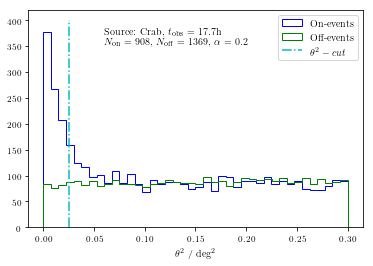

In [26]:
crab_events_sel_on = np.array(crab_events_sel_plot.theta_deg.values)
plt.hist((crab_events_sel_on)**2, bins =40, histtype='step', color='blue', label='On-events')

plt.hist(np.array(theta_deg_off)**2, bins=40, histtype='step', color='g', label='Off-events', weights=np.array([0.2 for el in theta_deg_off]))
plt.vlines(0.025, color='c', linestyle='-.', ymin=0, ymax=400, label=r'$\theta^{2}-cut$')
plt.xlabel(r'$\theta^2$ / $\deg^2$')
plt.legend()
plt.text(0.06, 350,
         r'''Source: Crab, $t_\mathrm{{obs}}$ = 17.7h
        $N_\mathrm{{on}}$ = {non}, $N_\mathrm{{off}}$ = {noff}, $\alpha$ = 0.2'''.format(non=len(crab_events_sel), noff=len(bkg)))
plt.savefig('On_Off.pdf')
print(len(crab_events_sel_1.theta_deg_off_1.values))

# 2D-Scatterplot der Energien

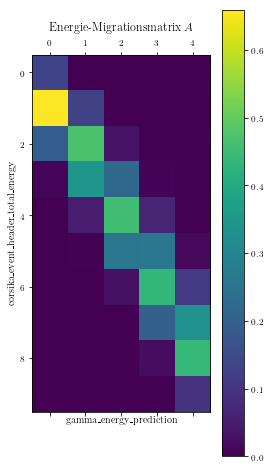

In [27]:
matrix, xedge, yedge = np.histogram2d(
    gammas_sel['gamma_energy_prediction'],
    gammas_sel['corsika_event_header_total_energy'], 
                                         bins=[
                                             np.logspace(np.log10(500),np.log10(35e3),11),
                                             np.logspace(np.log10(500),np.log10(35e3),6),
                                         ])
matrix = matrix/np.sum(matrix,axis=0) #hier erfolgt die Normierung
plt.matshow(matrix)
plt.xlabel('gamma\_energy\_prediction')
plt.ylabel('corsika\_event\_header\_total\_energy')
plt.title('Energie-Migrationsmatrix $A$')
plt.colorbar()
plt.savefig('Matrix.pdf')

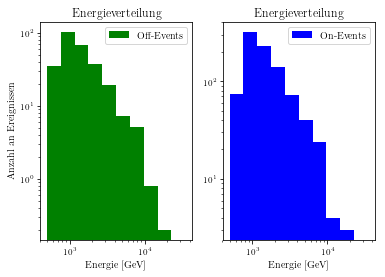

In [28]:
# Untergrund binnen
plt.subplot(1,2,1)
a = np.full_like(bkg['gamma_energy_prediction'], 0.2)
b, bins, p = plt.hist(bkg['gamma_energy_prediction'], bins=xedge, weights=a, color='g', label='Off-Events')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energie [GeV]')
plt.ylabel('Anzahl an Ereignissen')
plt.legend()
plt.title('Energieverteilung')
plt.subplot(1,2,2)
g, bins, p = plt.hist(crab_events_sel['gamma_energy_prediction'], bins=xedge, color='blue', label='On-Events')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energie [GeV]')
plt.legend()
plt.title('Energieverteilung')
plt.savefig('Energieverteilung_UG_SIG.pdf')

In [29]:
# Penrose-Moore Pseudoinverse ausrechnen (nicht quadratisch)
inv = np.linalg.pinv(matrix)
print(inv)

[[ 0.33643297  1.50110774 -0.15533712 -0.36192728  0.14070553  0.0768276
  -0.05509724 -0.0155591   0.02137087  0.00555307]
 [-0.18152643 -0.43832761  1.54091908  1.02353716 -0.4754592  -0.24584186
   0.17909449  0.05039439 -0.06939215 -0.01802729]
 [ 0.06161268  0.12998681 -0.50560533  0.38330731  1.72793777  0.62372859
  -0.58607351 -0.15582958  0.22598696  0.05847763]
 [-0.02198782 -0.0460539   0.18006029 -0.16551888 -0.4715683   0.74473224
   1.7909648   0.33847285 -0.70243549 -0.17781335]
 [ 0.00720985  0.01509793 -0.05905771  0.05532326  0.14818446 -0.26576238
  -0.35419594  0.89254786  1.61903826  0.36845907]]


Unfolded: [282.90780839 227.4783874   89.66708523  33.4244511   -0.42520451]
 shape (5,)
[282.90780839 227.4783874   89.66708523  33.4244511   -0.42520451]


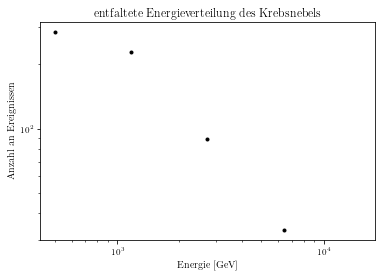

In [58]:
# Naive Entfaltung
ev = g-b
print('Unfolded: {}\n shape {}'.format(inv.dot(ev), np.shape(inv.dot(ev))))
plt.plot(yedge[:-1], inv.dot(ev), 'k.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energie [GeV]')
plt.ylabel('Anzahl an Ereignissen')
plt.title('entfaltete Energieverteilung des Krebsnebels')
plt.savefig('Entfaltung_1.pdf')
fNSVD = inv@ev

In [56]:
#negative Log-Likelihood-Entfaltung
f, bins = np.histogram(gammas_sel['corsika_event_header_total_energy'], bins=yedge)
lam = matrix@f+b 
#hier wurden die physikalischen Werte für f eingesetzt aus der Simulation
#es muss eigentlich ein allgemeiner Vektor f (dim 5) eingesetzt werden

negLog = 0
print(np.shape(f))
for i in range(len(g)):
    negLog += - g[i]*np.log(lam[i]) + lam[i]
    for val in range(1, int(g[i]), 1):
        negLog += np.log(val)
    
    print('''
    i = {} g[i] = {} lam[i] = {} -ln(L) = {}
    '''.format(i, g[i], lam[i], negLog)
         )
fent = np.argmin(negLog)
print(fent)

(5,)

    i = 0 g[i] = 74.0 lam[i] = 5458.0 -ln(L) = 5064.51085910913
    

    i = 1 g[i] = 317.0 lam[i] = 34365.200000000004 -ln(L) = 37625.32096597344
    

    i = 2 g[i] = 232.0 lam[i] = 38408.99999999999 -ln(L) = 74615.15704126401
    

    i = 3 g[i] = 141.0 lam[i] = 28183.8 -ln(L) = 101909.42046545917
    

    i = 4 g[i] = 73.0 lam[i] = 15652.40392670157 -ln(L) = 117095.74105707354
    

    i = 5 g[i] = 40.0 lam[i] = 8907.231413612564 -ln(L) = 125745.81948117915
    

    i = 6 g[i] = 24.0 lam[i] = 4240.425130890052 -ln(L) = 129837.39323619887
    

    i = 7 g[i] = 4.0 lam[i] = 2059.467539267016 -ln(L) = 131868.131723926
    

    i = 8 g[i] = 3.0 lam[i] = 826.0769633507853 -ln(L) = 132674.7517706219
    

    i = 9 g[i] = 0.0 lam[i] = 149.19502617801047 -ln(L) = 132823.9467967999
    
0


In [ ]:
FlussNSVD = fNSVD / (Aeff)

In [ ]:
#f, bins = np.histogram(gammas_sel['corsika_event_header_total_energy'], bins=yedge)
#b, bins = np.histogram(bkg['gamma_energy_prediction'], bins=xedge)
#lam = matrix@f+b
#bincenter = (bins[:-1]+bins[1:])/2
#plt.hist(bincenter, bins=bins, weights=lam)
#plt.xscale('log')
#plt.yscale('log')
#print(lam)
#plt.figure()
#plt.plot(bincenter, lam)
#plt.xscale('log')
#plt.yscale('log')